# Image Classification using AWS SageMaker

In this project, we will be using AWS Sagemaker to finetune a pretrained model that can perform image classification. We will have to use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices.

In [ ]:
!pip install smdebug

In [1]:
import sagemaker

## Dataset
We will use the dog breed classication dataset to classify between different breeds of dogs in image.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [2]:
sagemaker_session = sagemaker.Session()

bucket = "my-project-bucket-123"
prefix = "dogImages"
region ="us-east-1" 
role = "arn:aws:iam::657240468511:role/service-role/AmazonSageMaker-ExecutionRole-20211225T133929"

print("Default Bucket: {}".format(bucket))
print("Prefix: {}".format(prefix))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: my-project-bucket-123
Prefix: dogImages
AWS Region: us-east-1
RoleArn: arn:aws:iam::657240468511:role/service-role/AmazonSageMaker-ExecutionRole-20211225T133929


In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/

## Hyperparameter Tuning

In [3]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([10, 50, 100, 500, 1000]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "Testing Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [4]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [7]:
# TODO: Fit your HP Tuner
input_data = "s3://{}/dogImages".format(bucket)
tuner.fit({
'train': input_data+'/train',     
'val': input_data+'/valid',  
'test': input_data+'/test'     
}) # TODO: Remember to include your data channels

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-25 20:06:25 Starting - Preparing the instances for training
2021-12-25 20:06:25 Downloading - Downloading input data
2021-12-25 20:06:25 Training - Training image download completed. Training in progress.
2021-12-25 20:06:25 Uploading - Uploading generated training model
2021-12-25 20:06:25 Completed - Training job completed


{'_tuning_objective_metric': '"Testing Accuracy"',
 'batch_size': '"50"',
 'epochs': '3',
 'lr': '0.052476142859684716',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-25-18-56-40-478"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-657240468511/pytorch-training-2021-12-25-18-56-40-478/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

In [14]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                     rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                     "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

import sagemaker
from sagemaker.pytorch import PyTorch

In [15]:
input_data = "s3://{}/dogImages".format(bucket)
print("The input data will be {}".format(input_data))

The input data will be s3://my-project-bucket-123/dogImages


In [78]:
lr = float(best_estimator.hyperparameters()["lr"])
epochs = int(best_estimator.hyperparameters()['epochs'])
batch_size = int(best_estimator.hyperparameters()['batch_size'][1:-1])

print(lr)
print(batch_size)
print(epochs)

0.052476142859684716
50
3


In [79]:
hyperparameters = {
    "lr": lr,
    "batch_size": batch_size,
    "epochs": epochs
}

In [80]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = sagemaker.pytorch.estimator.PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    hyperparameters = hyperparameters,
    rules=rules,
    output_path=input_data
)

In [81]:
estimator.fit({
'train': input_data+'/train',     
'test': input_data+'/test',      
}, wait=True)

2021-12-26 03:05:02 Starting - Starting the training job...
2021-12-26 03:05:10 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-26 03:06:28 Starting - Preparing the instances for training.........
2021-12-26 03:08:01 Downloading - Downloading input data............
2021-12-26 03:10:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-26 03:10:00,849 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-26 03:10:00,857 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-26 03:10:00,873 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups 

In [82]:
pt_model_data = estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

Model artifact saved at:
 s3://my-project-bucket-123/dogImages/pytorch-training-2021-12-26-03-05-01-145/output/model.tar.gz


In [36]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2021-12-26-00-14-13-161
Region: us-east-1


In [37]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))


[2021-12-25 19:50:09.574 Robeds-MacBook-Air.local:8360 INFO s3_trial.py:42] Loading trial debug-output at path s3://my-project-bucket-123/dogImages/pytorch-training-2021-12-26-00-14-13-161/debug-output
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
2


In [38]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)

{0: array(5.0570817, dtype=float32), 500: array(0.73537385, dtype=float32)}

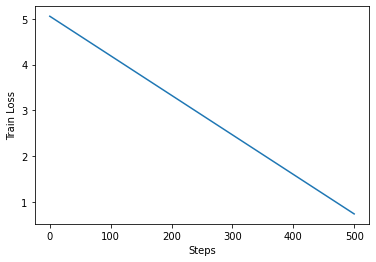

In [39]:
import matplotlib.pyplot as plt


plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()

If there were some anomalous behavior in your debugging output it would be that the loss is not decreasing so I would tune the parameters in the training job so that the loss would decrease.

In [40]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://my-project-bucket-123/dogImages', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://my-project-bucket-123/dogImages/pytorch-training-2021-12-26-00-14-13-161/profiler-output


Profiler data from system is available


In [41]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-25 19:58:52.491 Robeds-MacBook-Air.local:8360 INFO metrics_reader_base.py:134] Getting 30 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [42]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://my-project-bucket-123/dogImagespytorch-training-2021-12-26-00-14-13-161/rule-output


In [43]:
! aws s3 ls {rule_output_path} --recursive

In [44]:
! aws s3 cp {rule_output_path} ./ --recursive

In [45]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [46]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [64]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=34,
    destination_s3_uri=f"s3://{bucket}/data_capture",
)

In [86]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(instance_type="ml.m5.large", initial_instance_count=1) # TODO: Add your deployment configuration like instance type and number of instances


------!

In [84]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction
import torch
import torchvision
from torchvision import transforms

testing_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


testset = torchvision.datasets.ImageFolder(root="sample_image", 
            transform=testing_transform)
image = torch.utils.data.DataLoader(testset)
for input, label in image:
    print(predictor.predict(input))

[[-1.93566966  0.66263372 -2.42086744  3.00530648 -0.45431468  0.10046009
  -0.5739246  -0.17429234 -0.8964175   3.29441929 -1.56356037  1.95111024
  -1.04129088 -2.54394126 -0.3577655   1.35102212  0.05711174 -2.0350368
  -0.59310633 -2.41421056 -3.60940814 -2.19033122 -1.50945926  1.29500782
  -1.33080637 -0.55566728 -0.19111657 -1.57344496  0.05330128  0.58364391
   0.67466801 -1.5344336  -1.59852314 -2.28837681  0.94349694  0.96751118
   0.46317711 -0.22727665 -2.18153214  2.74803615 -1.16179395 -1.64791572
   1.72053039 -0.42277047  0.91025245  0.76196623 -0.08009881  0.22931087
   0.0969993   1.46206844  4.28050137  3.66242647  3.86773562  0.79056519
  -2.5299747   1.09648252 -2.03399301  1.17054832 -2.53993845 -0.40887836
   0.74406904 -0.34105751 -1.85831904  0.95399928 -1.78088915 -0.32329926
   1.14559329  0.49810353 -0.83926529 -0.27636805  0.29036155 -1.56742549
   0.5272854  -2.71763134 -1.47754967  4.90393686 -1.88604605 -2.24663854
   4.63192749 -1.71080148 -1.26217496  

In [87]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()